# DS Intern Project

## The Goal 

We are evaluating loans for investor interest. Our strategy is to build a working definition of what is a "good" loan. We'll use the loan_status label for this.

## The Data: First-Look Thoughts

The dataset contains loan information and customer metadata. It's a mix of categorical and numerical data. I'll give my thoughts on a brief inspection of it. I don't have domain knowledge here, so I will rely purely on data intuition. The lack of domain knowledge means I will probably be unable to think of meaningful features to add to the data.

### Individual vs. Joint

The data is broadly split into two parts: joint and individual loans. The joint loans comprise ~10% of the data. For a first-order model, I'll neglect these, as they contain an order-of-magnitude less data. It's worth further investigation to determine if a model can be built for this smaller dataset (which I imagine is biased towards "good_loan" status by having a cosigner), but let's keep it simple at first.

### Extraneous Fields

Several of the fields--job title, ZIP code, IDs--either don't contain relevant information, or have categorical information that is so sparsely populated it is unlikely to be helpful.

### Data Quality

The quality is quite good. Some columns need additional parsing. Examining only the individual loans, there are not many fields that contain a high amount missing data. We'll cull the extremely sparse columns and then build a strategy to fill the missing data in others.


In [1]:
#Run this notebook from the DS_Intern-master folder.
#Note: this code will create a few more .csv files in the data directory.
import os
repo_path=os.getcwd()+"/"
print(repo_path)

/Users/farmer/work/code/DS_Intern-master/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import pipeline 
import numpy as np
import seaborn as sns
import glob
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# First-Look Data Processing

In this first section, I'll perform some basic preprocessing to transform the data into a useful state. We'll combine all the data files and produce a single .csv with only the relevant, transformed data. Then we'll explore the data and do a second round.

In [3]:
path=repo_path+"data/"
joined_data_path=path+"loan_data_joined.csv"
cleaned_data_path=path+"loan_data_cleaned.csv"

def build_subtable(file):
    #Processes and tags the csv tables.
    subtable= pd.read_csv(file)
    stem = file[file.rfind('/')+1:file.rfind('.')]
    subtable.insert(1, "parent_file", stem, True)
    subtable.insert(1, "year",stem[0:4])
    return subtable

def select_individual_data(df):
    ''' Part of the clean_data_inplace chain. Removes joint loans.'''
    joint_indices = df[ (df['application_type'] != "Individual")].index
    df.drop(joint_indices, inplace=True)
    df.drop(["application_type", "annual_inc_joint", "dti_joint", "revol_bal_joint", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths"], axis=1, inplace=True)

def cull_sparse_columns(df):
    ''' Part of the clean_data_inplace chain. Decide handling for sparse columns. 
    We begin by conservatively dropping these columns; we can later examine more 
    sophisticated methods if necessary for model performance.'''
    occupancy_fraction = df.isnull().sum() / df.shape[0]
    occupancy_threshold=0.40
    to_drop=df.columns[occupancy_fraction > occupancy_threshold]
    df.drop(to_drop, axis=1, inplace=True)
    print("cull_sparse_columns: trimmed {} columns:".format(len(to_drop)))
    print(to_drop)

def cull_extraneous_columns(df):
    ''' Part of the clean_data_inplace chain. Some columns do not contain 
    sufficient information as to be useful (for instance, employment title, 
    which also requires correction for user input error). The dummy index
    columns may also be dropped.'''
    df.drop("emp_title", inplace=True,axis=1)
    df.drop("id", inplace=True,axis=1)
    df.drop("zip_code", inplace=True,axis=1)
    df.drop("parent_file", inplace=True,axis=1)
    df.drop("year", inplace=True,axis=1)
    
def format_columns(df):
    ''' Part of the clean_data_inplace chain. Performs basic processing and 
    formatting of a few columns. '''
    df['term']=df['term'].str[1:3].astype(int)
    df['int_rate'] = df['int_rate'].str[:-1].astype(float)/100
    df['revol_util'] = df['revol_util'].str[:-1].astype(float)/100
    #We have blank values in emp_length; err conservative and fill with the lowest ordinal category.
    df["emp_length"].fillna("< 1 year", inplace=True)
    df.loc[df["emp_length"] == "< 1 year", "emp_length"] = 0
    df.loc[df["emp_length"] == "1 year", "emp_length"] = 1
    df.loc[df["emp_length"] == "10+ years", "emp_length"] = 10
    for i in range(1,10): 
        df.loc[df["emp_length"] == "{} years".format(i), "emp_length"] = i
    ''' Earliest_cr_line contains dates of format 19xx and 20xx; let's extract the raw 
    values and then convert them into something more useful; since the data comes from 
    2016-2018, let's take anything above 20 and assume that is from 19xx.'''
    df['earliest_cr_line']=df['earliest_cr_line'].str[-2:].astype(int)
    df.loc[df['earliest_cr_line'] > 20, 'earliest_cr_line'] = df['earliest_cr_line']+1900
    df.loc[df['earliest_cr_line'] < 20, 'earliest_cr_line'] = df['earliest_cr_line']+2000
    df['earliest_cr_line'] = df['year'] - df['earliest_cr_line']

def clean_data_inplace(df):
    ''' Does basic first-look data cleaning tasks. '''
    select_individual_data(df)
    format_columns(df)
    cull_sparse_columns(df)
    cull_extraneous_columns(df)

#Construct a master dataset from the set of .csv files.
loan_data=0
subtables=[]
for file in glob.glob(path+"*Q*.csv"):
    subtables.append(build_subtable(file))
loan_data=pd.concat(subtables)
loan_data.to_csv(joined_data_path,index=False)

#Basic preprocessing of the master dataset.
df = pd.read_csv(joined_data_path)
clean_data_inplace(df)
df.to_csv(cleaned_data_path, index=False)

/Users/farmer/work/code/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


cull_sparse_columns: trimmed 3 columns:
Index(['mths_since_last_delinq', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq'],
      dtype='object')


# Second Data Cleaning

## Missing Data

Here, we examine the data and build a strategy to fill all missing fields. By the end of this section, we'll check if there is any missing data and throw an exception if there is.

In [4]:
df = pd.read_csv(cleaned_data_path)
missing_data=df.isnull().sum()
print(missing_data.loc[missing_data > 0])

revol_util                306
open_act_il                27
open_il_24m                27
il_util                 55498
open_rv_24m                27
all_util                   62
inq_last_12m               27
bc_open_to_buy           4568
bc_util                  4754
mths_since_recent_bc     4307
percent_bc_gt_75         4594
dtype: int64


We have remaining 11 columns with missing data, and the highest fraction is about 12%. Let's examine the data again, get a feel for the fields, and decide a strategy to fill them. At the end of this step we should have no missing data. This cell will throw an exception if that is not true.

In [5]:
#mean of 0.4, sigma of 0.2 -- estimate mean. 
df["revol_util"].fillna(df["revol_util"].mean(), inplace=True)

#installments: integers, estimate mode
df["open_act_il"].fillna(df["open_act_il"].mode()[0], inplace=True)
df["open_il_24m"].fillna(df["open_il_24m"].mode()[0], inplace=True)
df["il_util"].fillna(df["il_util"].mode()[0], inplace=True)

df["open_rv_24m"].fillna(df["open_rv_24m"].mode()[0], inplace=True)

#mean 58, sd 20 -- estimate the mean.
df["all_util"].fillna(df["all_util"].mean(), inplace=True)

#We have inq_last_6m: estimate by doubling. The missing data is trivial 
#(100% correlation with the other field), but it is only 27 records.
df["inq_last_12m"].fillna(df["inq_last_6mths"]*2, inplace=True)

#bankcards: broad spectrum of values, estimate mean
df["bc_open_to_buy"].fillna(df["bc_open_to_buy"].mean(), inplace=True)
df["bc_util"].fillna(df["bc_util"].mean(), inplace=True)
df["mths_since_recent_bc"].fillna(df["mths_since_recent_bc"].mean(), inplace=True)
df["percent_bc_gt_75"].fillna(df["percent_bc_gt_75"].mean(), inplace=True)

#Now, verify that we have no missing data:
missing_data=df.isnull().sum()
if (len(missing_data.loc[missing_data > 0] != 0)):
        raise Exception("Data is missing!")
else:
    print("No missing values!")

No missing values!


## Correlations & Redundancies

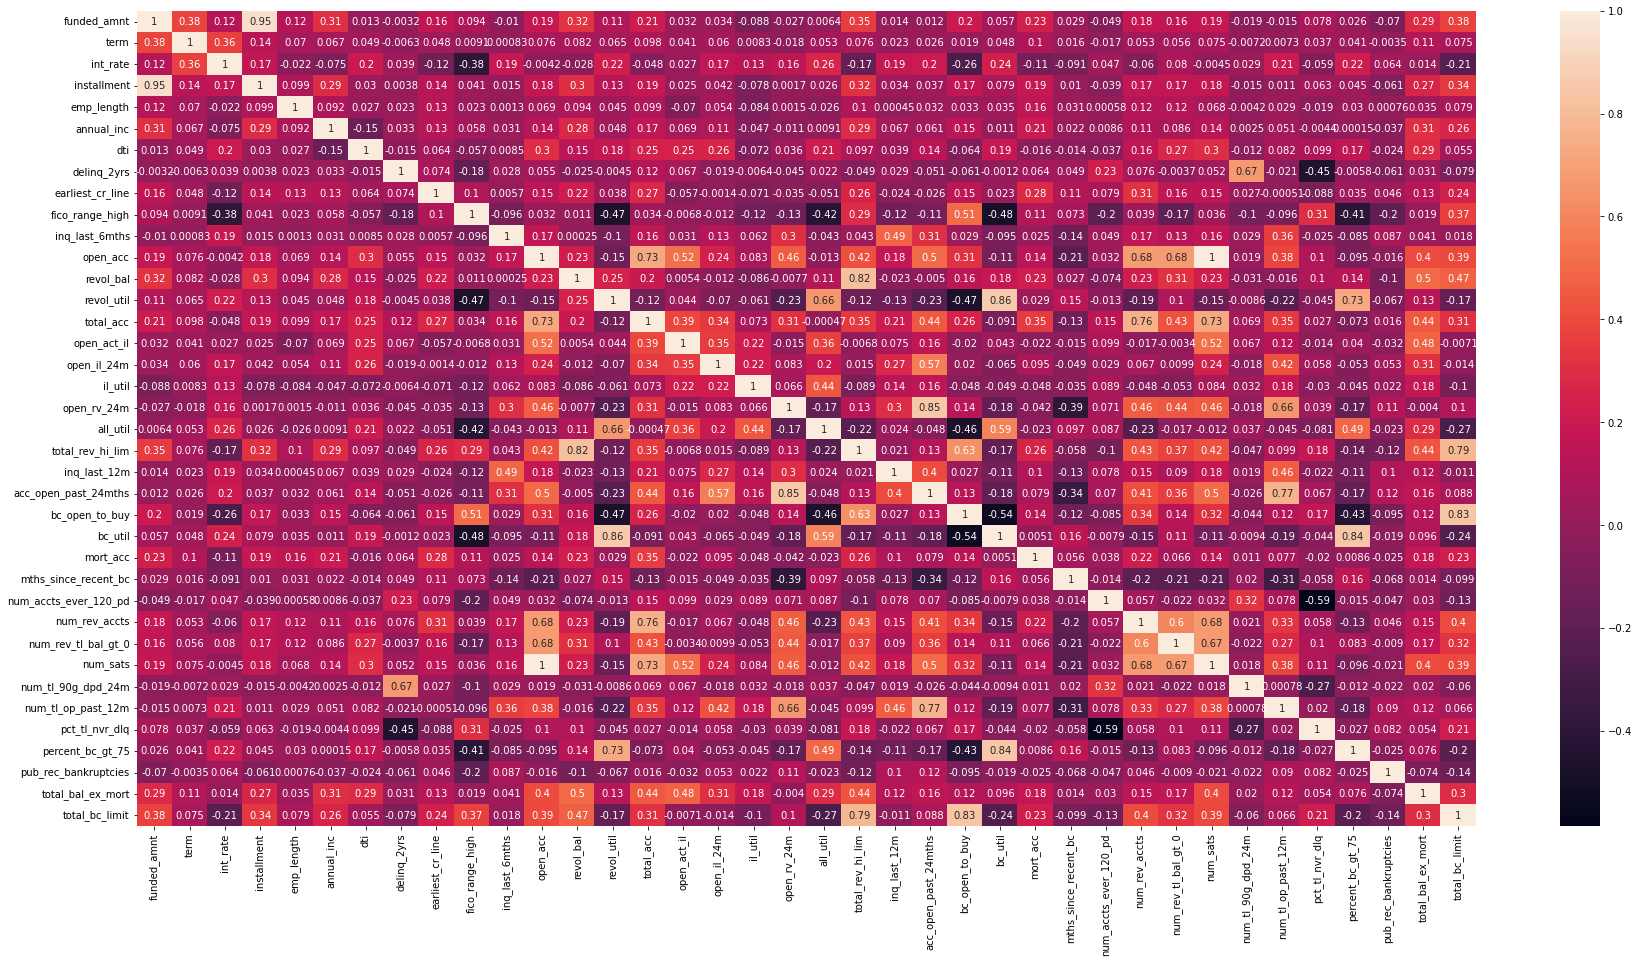

In [6]:
fig, ax = plt.subplots(figsize=(30,15))
cm_df = sns.heatmap(df.corr(),annot=True, ax=ax)
plt.show()

From this, we can extract a list of correlated pairs:
- Installment and funded_amnt; drop installment
- num_sats and open_acc; drop num_sats

Several other pairs show high correlation (R > 0.85), but we choose to leave them in.

In [7]:
df.drop("installment", axis=1, inplace=True)
df.drop("num_sats", axis=1, inplace=True)

## Pruning

Some columns need some final manual tuning. The columns can be split into three broad categories:
- Continuous, constrained numerical fields (eg dti, which appears to have been preselected as dti < 50) 
- Categories (eg home ownership) and discrete numerical fields (eg loan length, employment length).
- Unconstrained, continuous fields (eg income))

Each of these requires a different check. Respectively, we will:
- Ensure the data follows the expected constraints (no egregious input errors)
- Prune sparsely-populated categories.
- Look for fields with gross outliers.

# Gross Outliers
The annual income section, in particular, contains extreme outliers. Let's prune them so they don't confound the model. Preliminarily, by inspection, I'll cull all incomes greater than 5E5, and then we'll look at the distribution of the remaining values.

<AxesSubplot:>

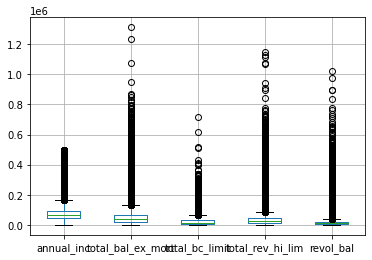

In [8]:
extreme_income_outliers = df[df['annual_inc'] > 5E5].index
df.drop(extreme_income_outliers,inplace=True)
df.boxplot(column=["annual_inc", "total_bal_ex_mort", "total_bc_limit", "total_rev_hi_lim","revol_bal"])

Since these distributions are highly non-Gaussian, the boxplots must be viewed with some skepticism. We don't wish to remove all outliers; instead, we just want to shorten the obscenely long tail of annual_inc so it doesn't confuse the model.

## Pruning

The dti column contains one entry that is -1. Prune it.

In [9]:
dti_outlier = df[df['dti'] == -1].index
df.drop(dti_outlier,inplace=True)

The "purpose" field contains several underpopulated categories. Let's drop them.

In [10]:
df["purpose"].explode().value_counts()


debt_consolidation    230449
credit_card            86492
home_improvement       31034
other                  29457
major_purchase         10187
medical                 5856
car                     4862
small_business          4667
vacation                3469
moving                  3295
house                   2401
renewable_energy         283
educational                1
Name: purpose, dtype: int64

In [11]:
purpose_outlier = df[(df['purpose'] == "renewable_energy") | (df['purpose'] == "educational")].index
df.drop(purpose_outlier,inplace=True)

The "home_ownership" field contains several underpopulated categories. Let's drop them.

In [12]:
df["home_ownership"].explode().value_counts()

MORTGAGE    196529
RENT        165260
OWN          50119
ANY            260
NONE             1
Name: home_ownership, dtype: int64

In [13]:
ownership_outlier = df[(df['home_ownership'] == "NONE") | (df['home_ownership'] == "ANY")].index
df.drop(ownership_outlier,inplace=True)

## Target Variable

Next, let's construct a target variable. Though ideally we'd like to build a numerical score for each loan, we'll start with simply ascribing a "goodness" criterion based on the "loan_status" variable. Let's examine the variable:

In [14]:
df["loan_status"].explode().value_counts()

Current               232472
Fully Paid            126898
Charged Off            39317
Late (31-120 days)      7535
In Grace Period         3623
Late (16-30 days)       2063
Name: loan_status, dtype: int64

Of these, three are "good" and the rest are "bad."

In [15]:
df["is_good_loan"] = np.where((df.loan_status == "Current") | (df.loan_status == "Fully Paid") | (df.loan_status== "In Grace Period"), 1, 0)
df["is_good_loan"].explode().value_counts()

1    362993
0     48915
Name: is_good_loan, dtype: int64

Now, we build our features and target. *It is vital to drop the loan_status column or the model will simply fit to it.*

In [16]:
X = df.iloc[:, df.columns != "is_good_loan"]
X.drop("loan_status", axis=1, inplace=True)

y = df["is_good_loan"]

/Users/farmer/work/code/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Fitting

Finally, we build the model. I'll describe the steps below.

### Preprocessing

The numerical data needs a scaler and the categorical data needs encoding. I'll use a OneHotEncoder for them all since the data are non-ordinal.

### Model

We'll use a logistic regressor. It's essential to adjust class weights because the good loans are at a ten-to-one ratio with the bad loans.

### Metrics

How do we define the "goodness" of a model? What we care about the most are false positives: we want to minimize the number of loans that are actually "bad" that are marked "good." Hence, the most important metric is precision, $$P = \frac{TP}{TP+FP}.$$  Because of the class imbalance, we would expect even the trivial model--always 1--to have high accuracy. *Our goal is not to beat it in accuracy, but to beat it in precision.*

After some experimenting, I found that the logisitic regressor works best. The decision tree sacrifices precision for accuracy and the random forest asymptotically approaches the trivial solution.

In [17]:
non_numerics=X.select_dtypes(include=object)
numerics=X.select_dtypes(include=np.number)
print("Non-numerics: \n{}".format(non_numerics))
idx_numerics=[X.columns.get_loc(col) for col in numerics]
idx_non_numerics=[X.columns.get_loc(col) for col in non_numerics]

Non-numerics: 
       home_ownership             purpose addr_state
0            MORTGAGE  debt_consolidation         OR
1                RENT  debt_consolidation         FL
2            MORTGAGE  debt_consolidation         CA
3            MORTGAGE         credit_card         NH
4                RENT  debt_consolidation         MN
...               ...                 ...        ...
413177       MORTGAGE  debt_consolidation         IN
413178       MORTGAGE  debt_consolidation         IL
413179           RENT  debt_consolidation         MD
413180       MORTGAGE  debt_consolidation         TX
413181           RENT         credit_card         MD

[411908 rows x 3 columns]


In [18]:
numeric_preprocessor = StandardScaler()
categorical_preprocessor=OneHotEncoder()

preprocessor = ColumnTransformer(transformers=[
    ("numeric", numeric_preprocessor, idx_numerics), 
    ("categorical", categorical_preprocessor, idx_non_numerics)])

classifier=LogisticRegression(class_weight="balanced", max_iter=1000)
pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])

In [19]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=90)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_pred,y_test))
print("F1: ", f1_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.20      0.65      0.31      9712
           1       0.93      0.66      0.77     72670

    accuracy                           0.65     82382
   macro avg       0.57      0.65      0.54     82382
weighted avg       0.85      0.65      0.72     82382

[[ 6266  3446]
 [24984 47686]]
Accuracy:  0.6549003423077857
F1:  0.770359121823557


# Quality Check

It's at first concerning that the model accuracy is lower than that of the trivial model, but accuracy is a poor metric for models with high class imbalances. As a sanity check, let's compare our model to a trivial "always yes" model.

In [20]:
y_pred_naive=np.empty(len(y_pred))
y_pred_naive.fill(1)

print(classification_report(y_test, y_pred_naive))
print(confusion_matrix(y_test, y_pred_naive))
print("Accuracy: ", accuracy_score(y_pred_naive,y_test))
print("F1:", f1_score(y_pred_naive, y_test))

/Users/farmer/work/code/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9712
           1       0.88      1.00      0.94     72670

    accuracy                           0.88     82382
   macro avg       0.44      0.50      0.47     82382
weighted avg       0.78      0.88      0.83     82382

[[    0  9712]
 [    0 72670]]
Accuracy:  0.882110169697264
F1: 0.937362949204138


Our model outperforms the trivial solution in precision by 5%. Again, we do not strongly strongly care about the false negatives (as you can simply pick another loan); we care about false positives.

In [21]:
X.to_csv(path+"final.csv", index=False)